# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [3]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


    ERROR: Command errored out with exit status 1:
     command: /opt/jupyterhub/bin/python3 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/setup.py'"'"'; __file__='"'"'/tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-5hwbniwo
         cwd: /tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/
    Complete output (5 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-02glc8l_/torch-scatter_1bd38de9738348cd870ba86fa835ffcf/setup.py", line 8, in <module>
        import torch
    M

In [4]:
!{sys.executable} -m pip install tqdm


  Using cached tqdm-4.61.1-py2.py3-none-any.whl (75 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/opt/jupyterhub/lib/python3.6/site-packages/tqdm'
Check the permissions.

You should consider upgrading via the '/opt/jupyterhub/bin/python3 -m pip install --upgrade pip' command.


### Import Dependencies

# System libraries

In [1]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training


/group/cake/leo/.venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
if "workspace" in os.getcwd():
    ROOT = "/workspace"
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake"


### Initialize Environment

In [3]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /group/cake
 - Project folder: /group/cake/our-git-project
 - Datasets folder: /data/training
 - Models folder: /group/cake/our-git-project/models
 - Experiments folder: /group/cake/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [4]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (2.0, 2.0, 2.0)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': 0.15
}


### Load Meta Data

In [5]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

Aneurysm Geometry  Angiography Data  Vessel Geometry  Labeled Mask Index  \
0          A001.stl  A001_orig.nii.gz  A001_vessel.stl                   1   
1          A003.stl  A003_orig.nii.gz  A003_vessel.stl                   1   
2          A005.stl  A005_orig.nii.gz  A005_vessel.stl                   1   
3          A006.stl  A006_orig.nii.gz  A006_vessel.stl                   1   
4          A008.stl  A008_orig.nii.gz  A008_vessel.stl                   1   

  Location  Age Sex  Rupture Status   Age Bin  Aneurysm Count  Case  \
0     Acom   48   m             1.0  (40, 50]               1  A001   
1     Pcom   58   f             0.0  (50, 60]               1  A003   
2     PICA   45   m             1.0  (40, 50]               1  A005   
3     ACom   46   f             1.0  (40, 50]               1  A006   
4      ACA   72   f             0.0  (70, 80]               1  A008   

                         Path Orig                         Path Mask  \
0  /data/training/A001_orig.nii.gz  /data/training/A001_masks.nii.gz   
1  /data/training/A003_orig.nii.gz  /data/training/A003_masks.nii.gz   
2  /data/training/A005_orig.nii.gz  /data/training/A005_masks.nii.gz   
3  /data/training/A006_orig.nii.gz  /data/training/A006_masks.nii.gz   
4  /data/training/A008_orig.nii.gz  /data/training/A008_masks.nii.gz   

                         Path Vessel                        Path Labeled Mask  
0  /data/training/A001_vessel.nii.gz  /data/training/A001_labeledMasks.nii.gz  
1  /data/training/A003_vessel.nii.gz  /data/training/A003_labeledMasks.nii.gz  
2  /data/training/A005_vessel.nii.gz  /data/training/A005_labeledMasks.nii.gz  
3  /data/training/A006_vessel.nii.gz  /data/training/A006_labeledMasks.nii.gz  
4  /data/training/A008_vessel.nii.gz  /data/training/A008_labeledMasks.nii.gz

### Load & Split MRI Data

In [6]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
# case_list = ["A009","A010","A012","A013","A014","A015"]
# df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

109
98
         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [7]:
from aneurysm_utils import preprocessing

most_common_shape=preprocessing.check_mri_shapes(mri_imgs_train)

print(most_common_shape)

Most common:
(70, 70, 60):      80
(35, 35, 31):       2
(36, 36, 30):       2
(55, 55, 49):       2
(36, 36, 31):       1
(70, 70, 60)


## Transform & Preprocess Data

In [8]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...
[INFO] Preprocessing: Intensity Segmentation...


In [9]:
size =(70,70,60)#(139, 139, 120)#(47,47,41)#
print(size)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))


(70, 70, 60)
Most common:
(70, 70, 60):      80
(array([0., 1.], dtype=float32), array([293988,     12]))


### Optional: View image


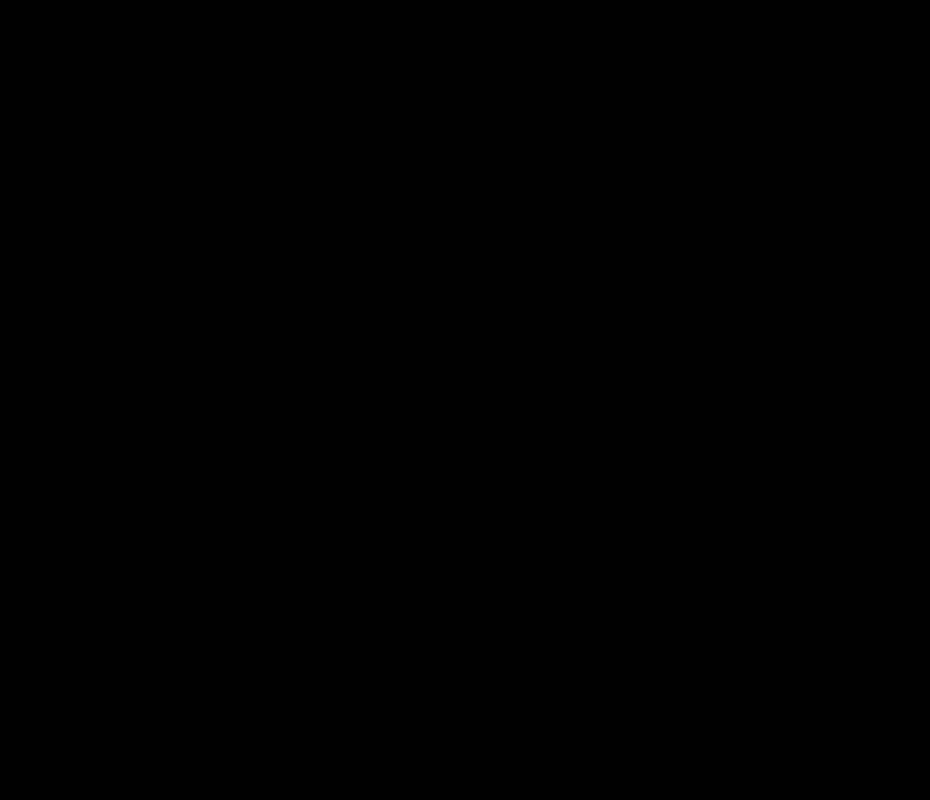
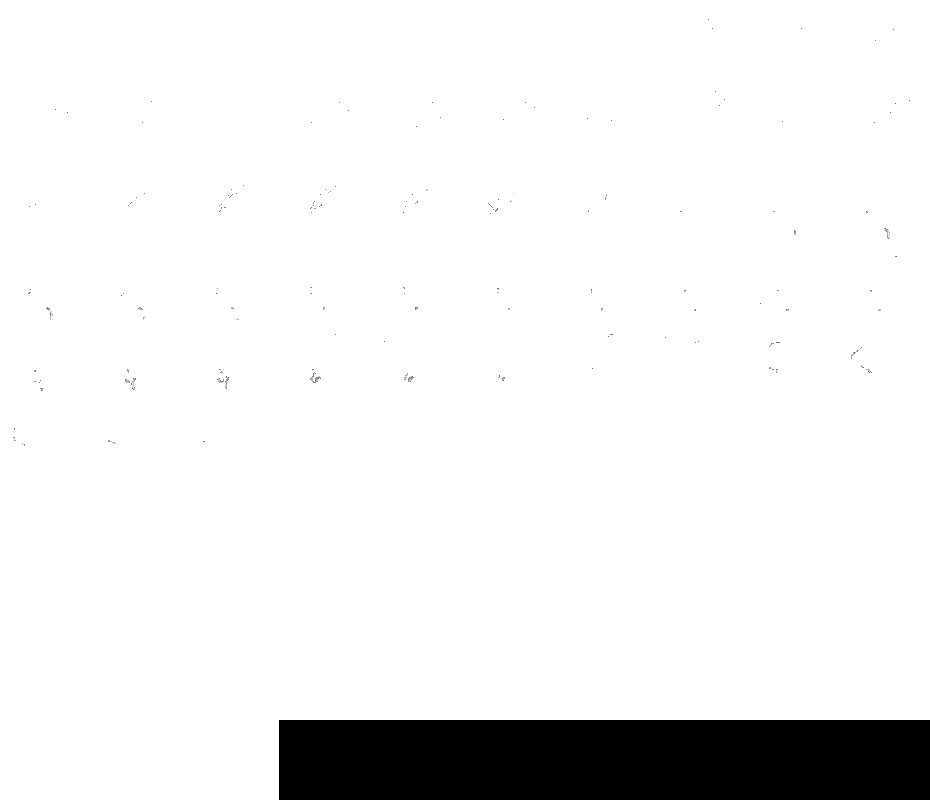

In [14]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [10]:
evaluation.plot_slices(mri_imgs_train[0])

0.0 1.0 None None


## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [11]:
from comet_ml import Optimizer

artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
# params = {
#     "batch_size": 3,
#     "epochs": 10,
#     "es_patience": None, # None = deactivate early stopping
#     "model_name": 'SegNet',
#     "optimizer_momentum": 0.9,
#     "optimizer":'Adam',
#     "learning_rate": 0.0001,
#     "criterion": "CrossEntropyLoss",
#     "sampler": None,   #'ImbalancedDatasetSampler2',
#     "shuffle_train_set": True,
#     "save_models": False,
#     "criterion_weights": [1.0, 1000.0],
#     "debug": True,
#     "weight_decay":0.01
# }
params = {
    "batch_size": 32,
    "epochs": 1000,
    "learning_rate": 2.6e-5, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.000003, # 1e-3
    "model_name": 'SegNet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 30.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": None,#"ReduceLROnPlateau", # "ReduceLROnP
    "debug":False,
    "dropout":0.38,
    "start_radius":0.2*int(most_common_shape[0]),
    "sample_rate1":0.2,
    "sample_rate2":0.25
    
}
params.update(dataset_params)
params.update(preprocessing_params)
config = {
    # We pick the Bayes algorithm:
    "algorithm": "bayes",
    # Declare your hyperparameters in the Vizier-inspired format:
    "parameters": {
#         "criterion_weights": {"type": "integer", "scalingType": "loguniform", "min": 1, "max": 10000},
#         "weight_decay": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e-3},
#         "learning_rate": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e2},
#         "scheduler": {"type": "categorical", "values": ["ReduceLROnPlateau", ""]},
#         "dropout":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.5},
        "start_radius":{"type":"float","scalingType":"loguniform","min":0.1*int(most_common_shape[0]),"max":0.25*int(most_common_shape[0])},
        "sample_rate1":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.3},
        "sample_rate2":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.3}
    },
    # Declare what we will be optimizing, and how:
    "spec": {"metric": "validate_bal_acc", "objective": "maximize"},  #test balance accuracy
}


opt = Optimizer(config, api_key=env.cached_data["comet_key"])

COMET INFO: COMET_OPTIMIZER_ID=7e8505a67b4e4a379d7bc9a9c0c7c602
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '7e8505a67b4e4a379d7bc9a9c0c7c602', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '7e8505a67b4e4a379d7bc9a9c0c7c602', 'parameters': {'sample_rate1': {'max': 0.3, 'min': 0.1, 'scalingType': 'loguniform', 'type': 'float'}, 'sample_rate2': {'max': 0.3, 'min': 0.1, 'scalingType': 'loguniform', 'type': 'float'}, 'start_radius': {'max': 17.5, 'min': 7.0, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'validate_bal_acc', 'minSampleSize': 100, 'objective': 'maximize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 13632663898, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'

In [ ]:
# Finally, get experiments, and train your models:
for comet_exp in opt.get_experiments(project_name=env.project+ "-" + params["prediction"]):
    print(comet_exp)
    param_copy = params.copy()
    comet_exp.params
    for key in config["parameters"].keys():
        param_copy[key]=comet_exp.get_parameter(key)
        print(param_copy[key])
#     param_copy["weight_decay"] = comet_exp.get_parameter("weight_decay")
#     param_copy["criterion_weights"] = comet_exp.get_parameter("criterion_weights")
#     param_copy["learning_rate"] = comet_exp.get_parameter("learning_rate")
#     param_copy["scheduler"] = comet_exp.get_parameter("scheduler")

    exp = env.create_experiment(
        params["prediction"] + "-pytorch-" + params["model_name"], comet_exp
    ) #params["selected_label"] + "-hyperopt-" + params["model_name"]
    exp.run(training.train_pytorch_model, param_copy, artifacts)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/28126eb45fcc47b69ef0a304ae776ced



12.838971369304135
0.1778760695689472
0.2804179284872279
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-16-14-46_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998408919123205
Balanced Accuracy (): 0.5303853678635515
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.08      0.06      0.07       263

    accuracy                           1.00   2646000
   macro avg       0.54      0.53      0.54   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/28126eb45fcc47b69ef0a304ae776ced
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.034124135971069336, 0.7022902369499207)
COMET INFO:     test_accuracy            : 0.9998408919123205
COMET INFO:     test_bal_acc             : 0.5303853678635515
COMET INFO:     test_f1                  : 0.07064017660044149
COMET INFO:     test_precision           : 0.08421052631578947
COMET INFO:     test_recall              : 0.060836501901140684
COMET INFO:     test_sen                 : 0.060836501901140684
COMET INFO:     test_spec                : 0.9999342338259622
COMET INFO:     train_accuracy [1000]    : (0.7628132480217921, 0.9843420457490764)
COMET INFO:     train_avg_loss [1000]    :

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 57 minutes 54 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/2e03369c1fc841f88fd789b931681a45



16.93722050220732
0.2029467871442862
0.1834713626250226
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-17-12-46_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine 

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998458049886622
Balanced Accuracy (): 0.5436944865539785
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.12      0.09      0.10       263

    accuracy                           1.00   2646000
   macro avg       0.56      0.54      0.55   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/2e03369c1fc841f88fd789b931681a45
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.038607124239206314, 0.7129194140434265)
COMET INFO:     test_accuracy            : 0.9998458049886622
COMET INFO:     test_bal_acc             : 0.5436944865539785
COMET INFO:     test_f1                  : 0.1013215859030837
COMET INFO:     test_precision           : 0.12041884816753927
COMET INFO:     test_recall              : 0.08745247148288973
COMET INFO:     test_sen                 : 0.08745247148288973
COMET INFO:     test_spec                : 0.9999365016250671
COMET INFO:     train_accuracy [1000]    : (0.7845138207746138, 0.9846571360326067)
COMET INFO:     train_avg_loss [1000]    : (0

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 1 hours 1 minutes 51 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/3d6e9b8e8777492f9bbcad96006f3854



7.186347387622191
0.13395719230390185
0.15613901098539876
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-18-14-42_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engin

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9997418745275888
Balanced Accuracy (): 0.7622519617902984
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.20      0.52      0.29       263

    accuracy                           1.00   2646000
   macro avg       0.60      0.76      0.64   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/3d6e9b8e8777492f9bbcad96006f3854
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.0412280298769474, 0.7116807103157043)
COMET INFO:     test_accuracy            : 0.9997418745275888
COMET INFO:     test_bal_acc             : 0.7622519617902984
COMET INFO:     test_f1                  : 0.28779979144942647
COMET INFO:     test_precision           : 0.19827586206896552
COMET INFO:     test_recall              : 0.5247148288973384
COMET INFO:     test_sen                 : 0.5247148288973384
COMET INFO:     test_spec                : 0.9997890946832584
COMET INFO:     train_accuracy [1000]    : (0.8258821257413516, 0.9821719884737942)
COMET INFO:     train_avg_loss [1000]    : (0.05

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 38 minutes 27 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/9308c14631bf4bab84fa20368acc7d72



10.30283053703024
0.2154100150612602
0.14618527348961444
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-18-53-15_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998824640967499
Balanced Accuracy (): 0.5836328036542653
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.32      0.17      0.22       263

    accuracy                           1.00   2646000
   macro avg       0.66      0.58      0.61   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/9308c14631bf4bab84fa20368acc7d72
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.030543938279151917, 0.6946527361869812)
COMET INFO:     test_accuracy            : 0.9998824640967499
COMET INFO:     test_bal_acc             : 0.5836328036542653
COMET INFO:     test_f1                  : 0.22055137844611528
COMET INFO:     test_precision           : 0.3235294117647059
COMET INFO:     test_recall              : 0.16730038022813687
COMET INFO:     test_sen                 : 0.16730038022813687
COMET INFO:     test_spec                : 0.9999652270803938
COMET INFO:     train_accuracy [1000]    : (0.7733738546214088, 0.9877318073477022)
COMET INFO:     train_avg_loss [1000]    : (0

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 1 hours 16 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/1c88163749dd42b4a0e7ae2d4df9bd7a



14.254138814986472
0.11317043483532586
0.13644107273073816
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-19-53-36_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:02
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engi

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9997777777777778
Balanced Accuracy (): 0.5892833103950532
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.11      0.18      0.14       263

    accuracy                           1.00   2646000
   macro avg       0.56      0.59      0.57   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/1c88163749dd42b4a0e7ae2d4df9bd7a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.050227612257003784, 0.7345393896102905)
COMET INFO:     test_accuracy            : 0.9997777777777778
COMET INFO:     test_bal_acc             : 0.5892833103950532
COMET INFO:     test_f1                  : 0.13782991202346043
COMET INFO:     test_precision           : 0.11217183770883055
COMET INFO:     test_recall              : 0.17870722433460076
COMET INFO:     test_sen                 : 0.17870722433460076
COMET INFO:     test_spec                : 0.9998593964555056
COMET INFO:     train_accuracy [1000]    : (0.7295763052106785, 0.9794784747597437)
COMET INFO:     train_avg_loss [1000]    : (

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 40 minutes 14 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/52e233ee5c5441178266667c724c48e2



13.7318254878199
0.17047541830576884
0.16549602820572415
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-20-33-55_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998718820861678
Balanced Accuracy (): 0.5151932508815519
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.09      0.03      0.05       263

    accuracy                           1.00   2646000
   macro avg       0.54      0.52      0.52   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/52e233ee5c5441178266667c724c48e2
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.03628413379192352, 0.7365208864212036)
COMET INFO:     test_accuracy            : 0.9998718820861678
COMET INFO:     test_bal_acc             : 0.5151932508815519
COMET INFO:     test_f1                  : 0.04507042253521127
COMET INFO:     test_precision           : 0.08695652173913043
COMET INFO:     test_recall              : 0.030418250950570342
COMET INFO:     test_sen                 : 0.030418250950570342
COMET INFO:     test_spec                : 0.9999682508125335
COMET INFO:     train_accuracy [1000]    : (0.8173492775792934, 0.9826141312910062)
COMET INFO:     train_avg_loss [1000]    : 

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 53 minutes 33 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/0531e36fec7040b094e3445082563487



16.25571735104551
0.12131482481890644
0.11830941480682293
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-21-27-33_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:03
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engin

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9997619047619047
Balanced Accuracy (): 0.5816715662935789
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.09      0.16      0.12       263

    accuracy                           1.00   2646000
   macro avg       0.55      0.58      0.56   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/0531e36fec7040b094e3445082563487
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.051347825676202774, 0.6989405155181885)
COMET INFO:     test_accuracy            : 0.9997619047619047
COMET INFO:     test_bal_acc             : 0.5816715662935789
COMET INFO:     test_f1                  : 0.12011173184357542
COMET INFO:     test_precision           : 0.09492273730684327
COMET INFO:     test_recall              : 0.1634980988593156
COMET INFO:     test_sen                 : 0.1634980988593156
COMET INFO:     test_spec                : 0.9998450337278422
COMET INFO:     train_accuracy [1000]    : (0.7688761949290793, 0.9810590082787431)
COMET INFO:     train_avg_loss [1000]    : (0.

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 42 minutes 26 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/3eaea2362ee740c0912b30bc36130ed9



14.974353584012949
0.17492389020998028
0.226257840054805
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-22-10-04_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.999884731670446
Balanced Accuracy (): 0.7033938947263886
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.42      0.41      0.41       263

    accuracy                           1.00   2646000
   macro avg       0.71      0.70      0.71   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/3eaea2362ee740c0912b30bc36130ed9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.036594219505786896, 0.7060921788215637)
COMET INFO:     test_accuracy            : 0.999884731670446
COMET INFO:     test_bal_acc             : 0.7033938947263886
COMET INFO:     test_f1                  : 0.4123314065510597
COMET INFO:     test_precision           : 0.41796875
COMET INFO:     test_recall              : 0.4068441064638783
COMET INFO:     test_sen                 : 0.4068441064638783
COMET INFO:     test_spec                : 0.9999436829888988
COMET INFO:     train_accuracy [1000]    : (0.7790861365357348, 0.9868830964227089)
COMET INFO:     train_avg_loss [1000]    : (0.04661843825

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 57 minutes 3 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/7a31d20b285c484c8c4e29126ba89a26



10.199396999337901
0.2743712295424599
0.12849004759206714
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-28-23-07-14_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:05
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engin

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy (): 0.9998764172335601
Balanced Accuracy (): 0.57792692481867
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2645737
         1.0       0.28      0.16      0.20       263

    accuracy                           1.00   2646000
   macro avg       0.64      0.58      0.60   2646000
weighted avg       1.00      1.00      1.00   2646000



COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/7a31d20b285c484c8c4e29126ba89a26
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [301]               : (0.02647758275270462, 0.7052803039550781)
COMET INFO:     test_accuracy            : 0.9998764172335601
COMET INFO:     test_bal_acc             : 0.57792692481867
COMET INFO:     test_f1                  : 0.20048899755501223
COMET INFO:     test_precision           : 0.2808219178082192
COMET INFO:     test_recall              : 0.155893536121673
COMET INFO:     test_sen                 : 0.155893536121673
COMET INFO:     test_spec                : 0.9999603135156669
COMET INFO:     train_accuracy [1000]    : (0.8057925791156128, 0.9890277431912547)
COMET INFO:     train_avg_loss [1000]    : (0.028117

[INFO] Experiment run completed: mask-pytorch-SegNet. Duration: 1 hours 13 minutes 12 seconds


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/25bc210239784112addd595bdc59c6c6



7.254437931240573
0.2263259854441107
0.2941780691802322
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-29-00-20-31_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 80
[INFO] Validation dataset loaded. Length: 11
[INFO] Engine run starting with max_epochs=1000.
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine run complete. Time taken: 00:00:01
[INFO] Training Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:00
[INFO] Engine run complete. Time taken: 00:00:00
[INFO] Validation Results - Epoch: 1 Bal Avg accuracy: 0.50 Avg loss: 0.69
[INFO] Epoch[1] Complete. Time taken: 00:00:04
[INFO] Engine run starting with max_epochs=1.
[INFO] Epoch[1] Complete. Time taken: 00:00:01
[INFO] Engine 

# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(training.train_pytorch_model, params, artifacts)

## Evaluate Model

Do evaluation, e.g. visualizations  

In [18]:
from aneurysm_utils.utils.pytorch_utils import predict

In [19]:
model = exp.artifacts["model"]

In [20]:
predictions = predict(model, mri_imgs_val, apply_softmax=False )

ValueError: too many values to unpack (expected 5)

In [ ]:
predictions[0][1]

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)